In [1]:
! pip install scikit-image

In [2]:
from scipy.ndimage import label

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import skimage
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#from utils import *
#from unet import *

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
#setting image parameters
im_width= 256
im_height= 256

# loading the image and mask paths

In [5]:
image_filenames_train=[]
# creating a list of all files containing the word 'mask'
mask_files=glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')
for i in mask_files:
    image_filenames_train.append(i.replace('_mask',''))
print(image_filenames_train[:10])
len(image_filenames_train)

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']


3929

In [6]:
def plot_from_img_path(rows,columns,list_image_path,list_mask_path):
    fig=plt.figure(figsize=(12,12))
    for i in range(1,rows*columns+1):
        fig.add_subplot(rows, columns, i)
        img_path=list_image_path[i]
        mask_path=list_mask_path[i]
        image = cv2.imread(img_path)
        image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask=cv2.imread(mask_path)
        mask= cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.imshow(mask,alpha=0.4)
    plt.show()

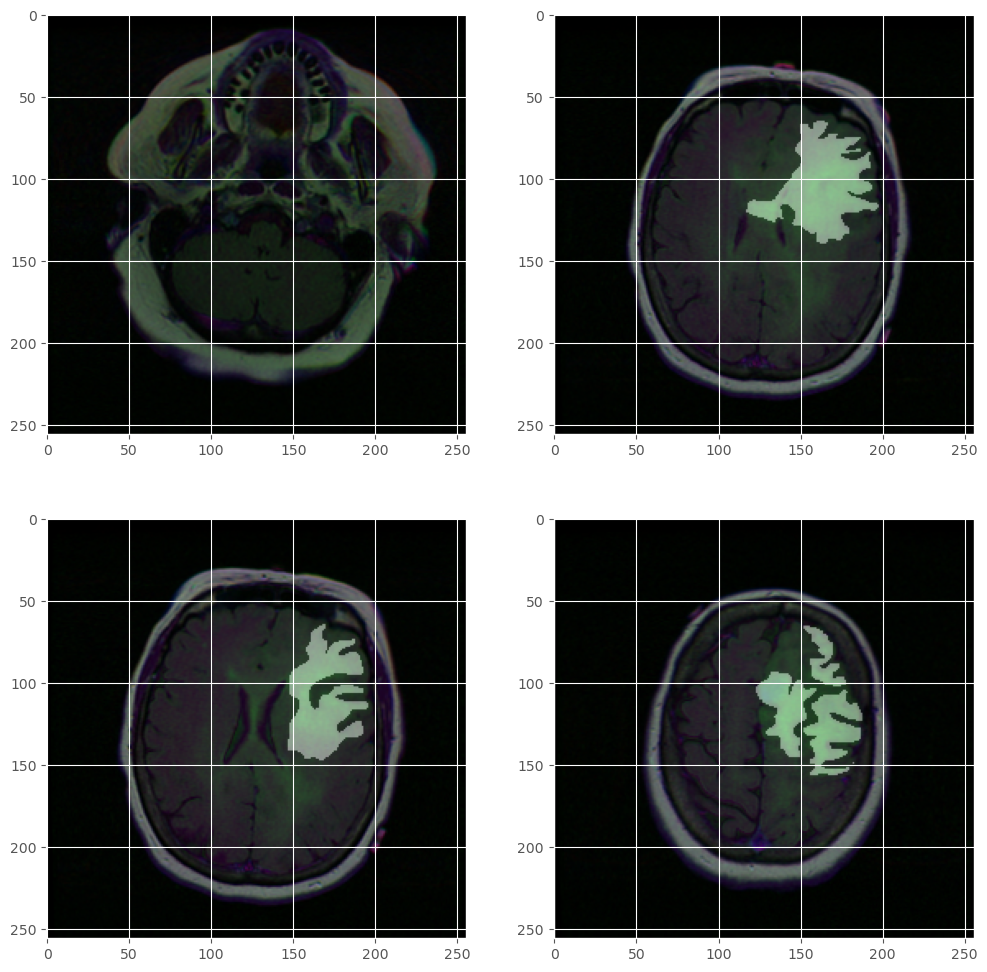

In [7]:
plot_from_img_path(2,2,image_filenames_train,mask_files)

# Create dataframe and split data on train set, validation set and test set


In [8]:
df=pd.DataFrame(data={'image_filenames_train':image_filenames_train,'mask':mask_files})
df_train,df_test=train_test_split(df,test_size=0.1)
print(df_train.shape)
print(df_test.shape)
df_train,df_val=train_test_split(df_train,test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(3536, 2)
(393, 2)
(2828, 2)
(708, 2)


In [9]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [10]:
def train_generator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode='grayscale',
                   mask_color_mode='grayscale',image_save_prefix="image",mask_save_prefix="mask",
                   flag_multi_class=False,num_class=2,save_to_dir=None,target_size=(256,256),seed=1):
    image_datagen=ImageDataGenerator(**aug_dict)
    mask_datagen=ImageDataGenerator(**aug_dict)
    image_generator=image_datagen.flow_from_director(
        train_path,
        classes=[image_folder],
        class_mode=None,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed
    )
    mask_generator = mask_datagen.flow_from_dataframe(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )
    
    train_generator = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_generator:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [11]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [12]:
def dice_coefficients(y_true,y_pred,smooth=100):
    y_true_flatten=K.flatten(y_true)
    y_pred_flatten=K.flatten(y_pred)
    
    intersection=K.sum(y_true_flatten*y_pred_flatten)
    union=K.sum(y_true_flatten)+K.sum(y_pred_flatten)
    return (2*intersection+smooth)/(union+smooth)
def dice_coefficient_loss(y_true,y_pred,smooth=100):
    return -dice_coefficients(y_true,y_pred,smooth)


In [13]:
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred): #same as iou loss. This iou is jaccard iou
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

In [14]:
def unet(input_size=(256, 256, 3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

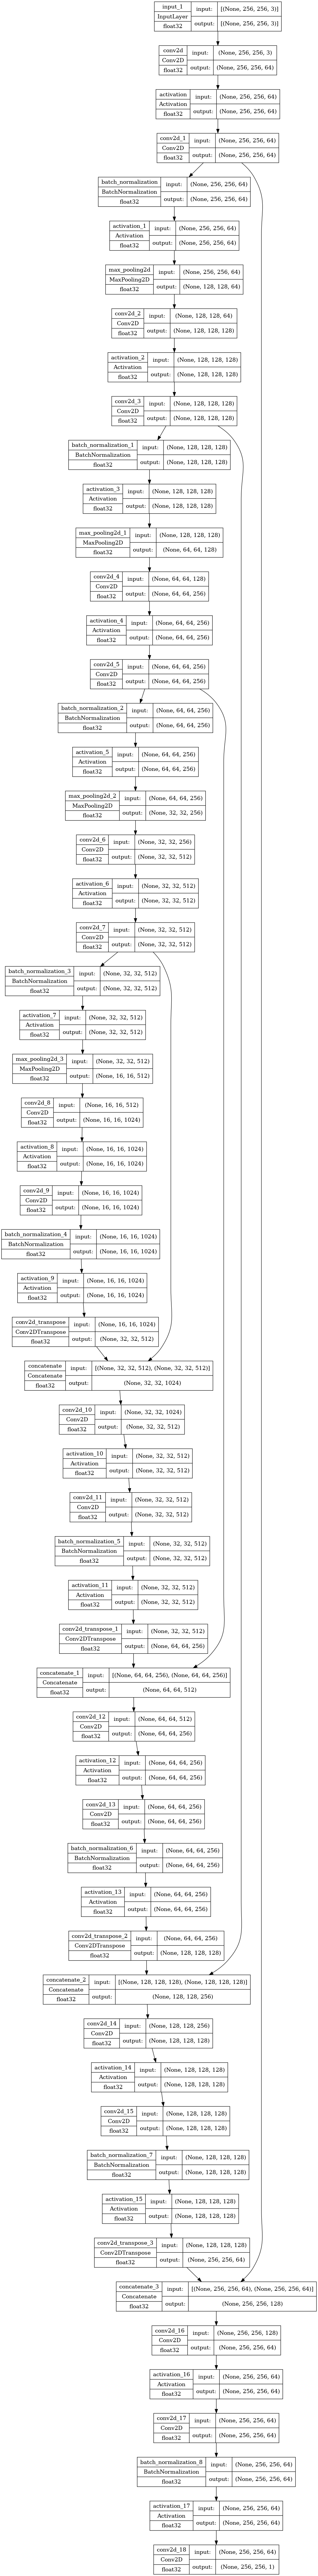

In [16]:
model = unet()
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True
)

In [17]:
train_generator_param=dict(rotation_range=0.2,
                          width_shift_range=0.05,
                           shear_range=0.05,
                           zoom_range=0.05,
                           horizontal_flip=True,
                           fill_mode='nearest')
train_gen=train_generator(df_train,BATCH_SIZE,train_generator_param,target_size=(im_height,im_width))
test_gen=train_generator(df_train,BATCH_SIZE,dict(),target_size=(im_height,im_width))
model = unet(input_size=[im_height, im_width,3])
decay_rate=learning_rate/EPOCHS
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=decay_rate,amsgrad=False)
model.compile(optimizer=optimizer,loss=dice_coefficient_loss,metrics=['binary_accuracy',iou,dice_coefficients])
callbacks=[ModelCheckpoint('unet.hdf5',verbose=1,save_best_only=True)]
history= model.fit(train_gen,
                   steps_per_epoch=len(df_train)/BATCH_SIZE,
                   epochs=EPOCHS,
                   callbacks=callbacks,
                   validation_data=test_gen,
                   validation_steps=len(df_test)/BATCH_SIZE
                   )


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: -1s - loss: -0.1049 - binary_accuracy: 0.9017 - iou: 0.0565 - dice_coefficients: 0.1051Found 2828 validated image filenames.
Found 2828 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02021, saving model to unet.hdf5
88/88 [==============================] - 226s 2s/step - loss: -0.1049 - binary_accuracy: 0.9017 - iou: 0.0565 - dice_coefficients: 0.1051 - val_loss: -0.0202 - val_binary_accuracy: 0.9897 - val_iou: 0.0103 - val_dice_coefficients: 0.0202
Epoch 2/100
89/88 [==============================] - ETA: -1s - loss: -0.1773 - binary_accuracy: 0.9860 - iou: 0.0984 - dice_coefficients: 0.1771
Epoch 2: val_loss did not improve from -0.02021
88/88 [==============================] - 151s 2s/step - loss: -0.1773 - binary_accuracy: 0.9860 - iou: 0.0984 - dice_coefficients: 0.1771 - val_loss: -0.0195 - val_binary_accuracy: 0.9828 - val_i

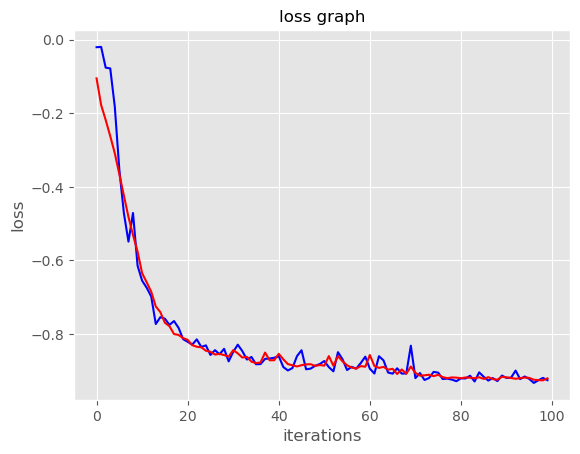

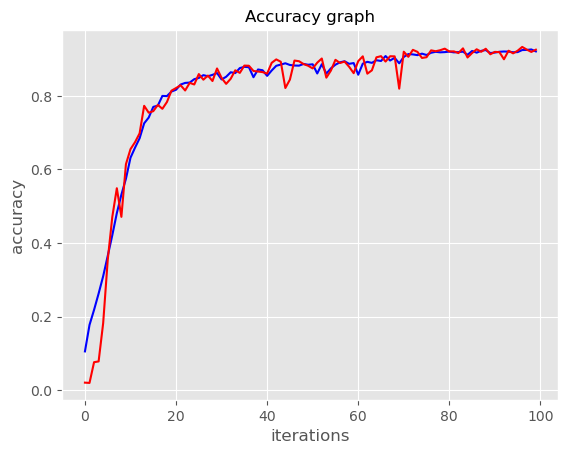

In [18]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

1/1 [==============================] - 2s 2s/step


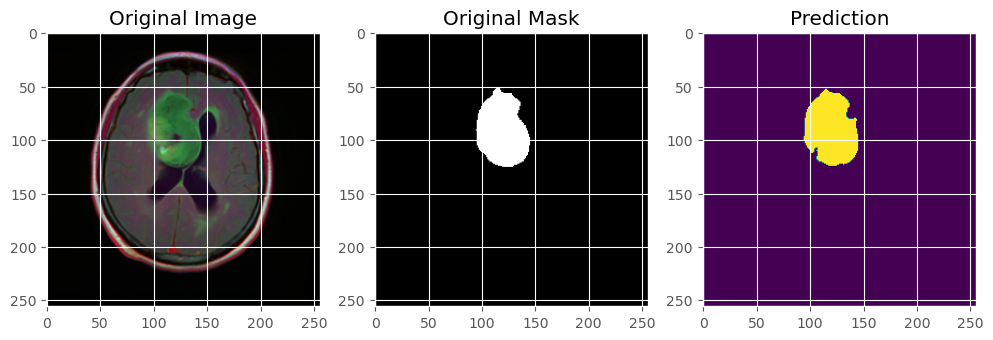

1/1 [==============================] - 0s 22ms/step


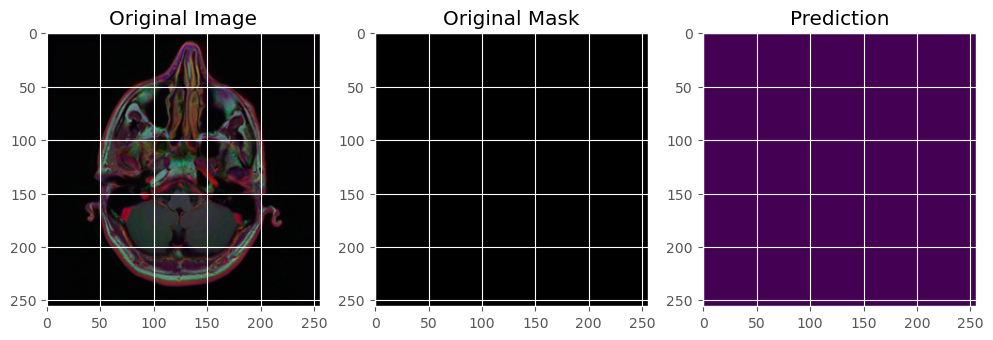

1/1 [==============================] - 0s 21ms/step


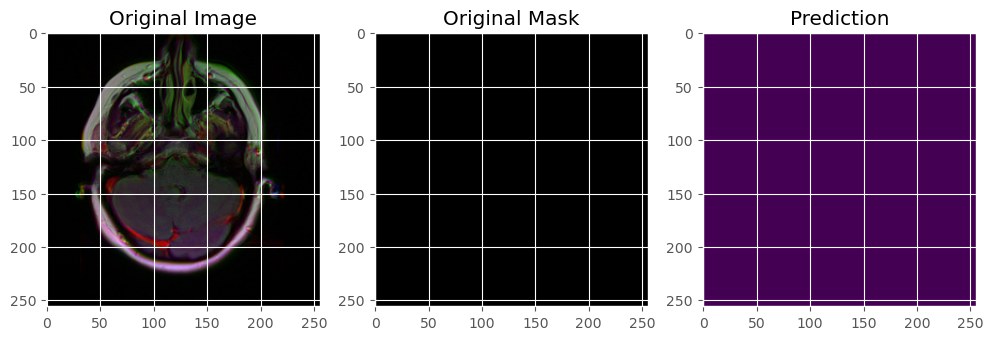

1/1 [==============================] - 0s 21ms/step


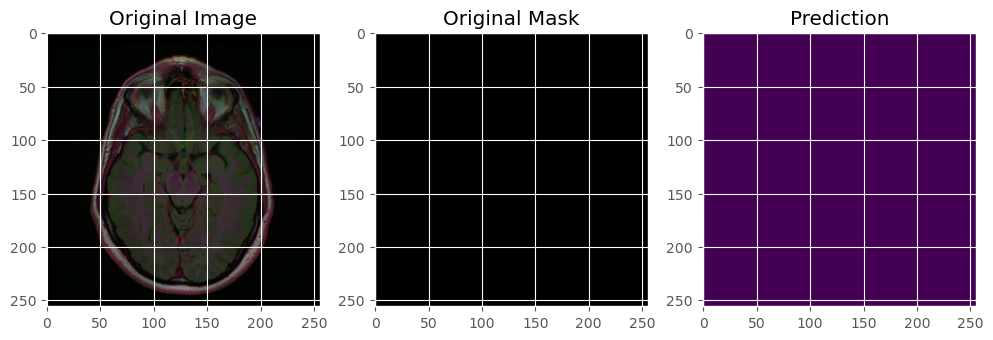

1/1 [==============================] - 0s 21ms/step


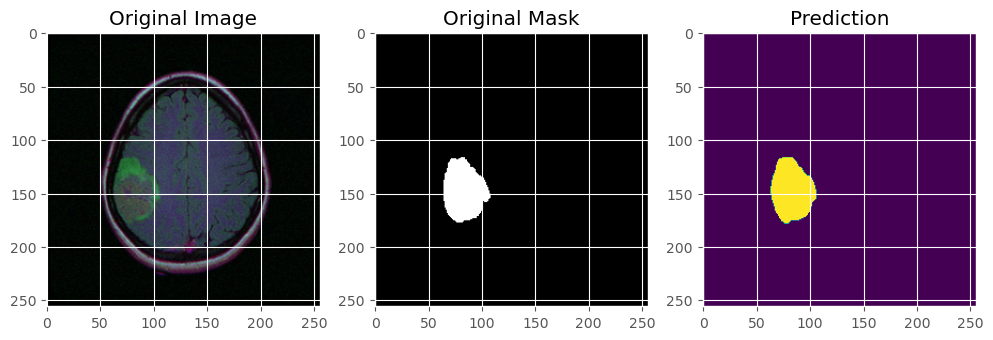

1/1 [==============================] - 0s 20ms/step


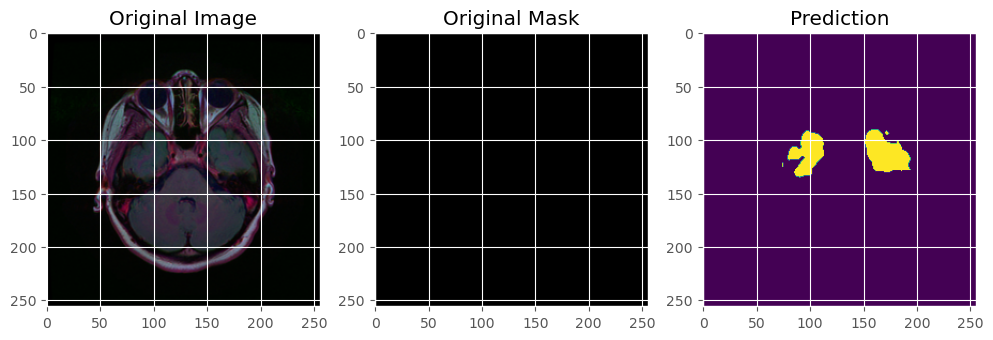

1/1 [==============================] - 0s 20ms/step


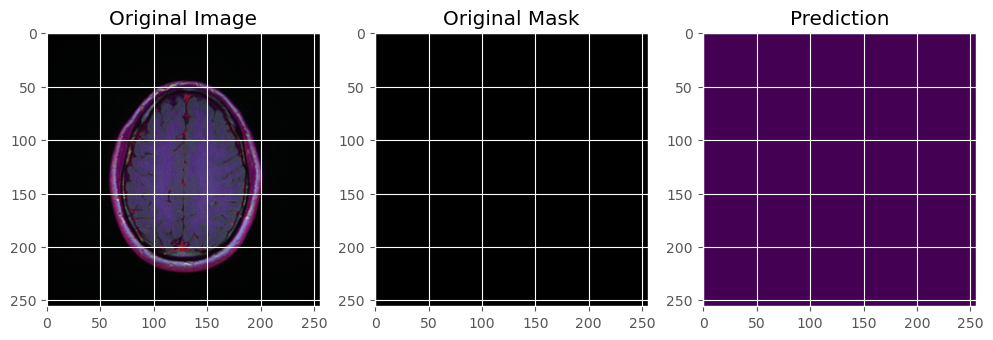

1/1 [==============================] - 0s 22ms/step


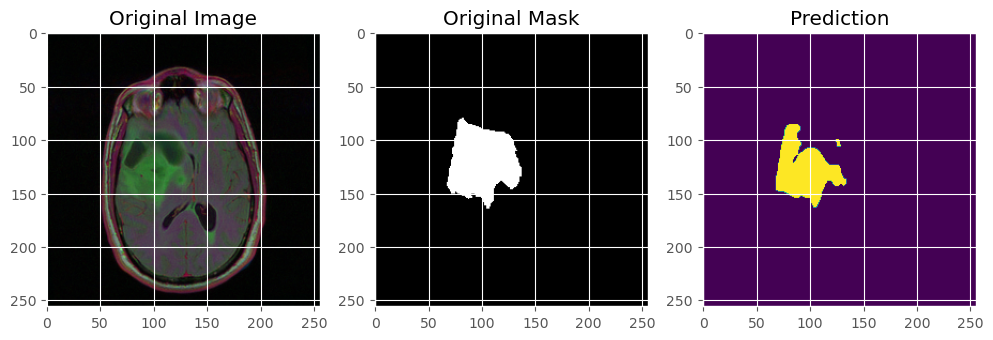

1/1 [==============================] - 0s 20ms/step


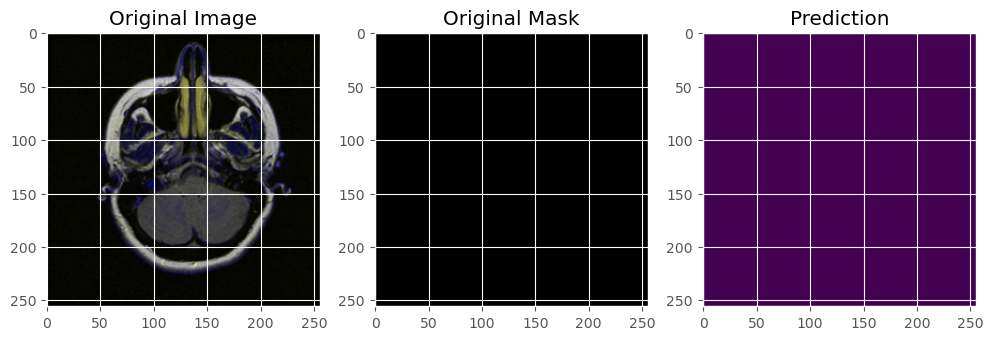

1/1 [==============================] - 0s 22ms/step


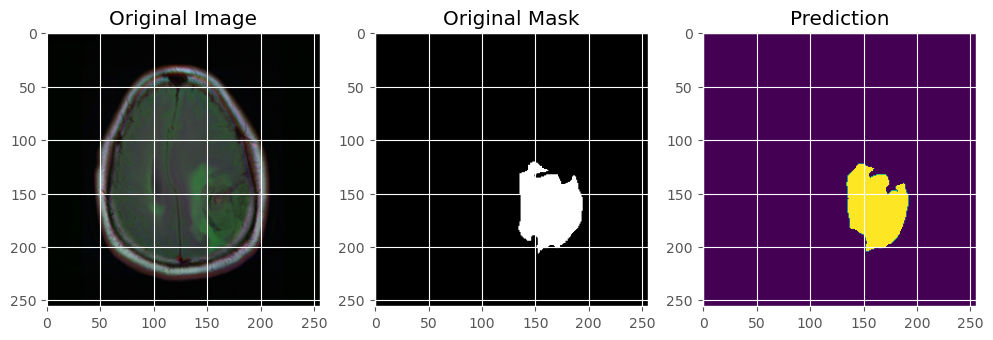

1/1 [==============================] - 0s 21ms/step


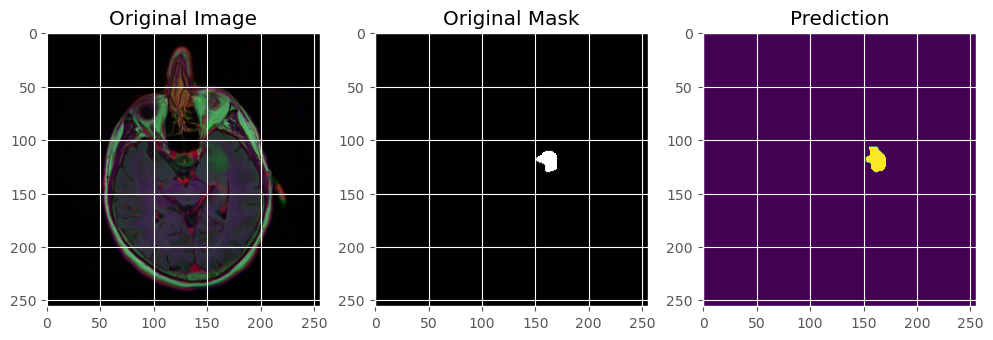

1/1 [==============================] - 0s 20ms/step


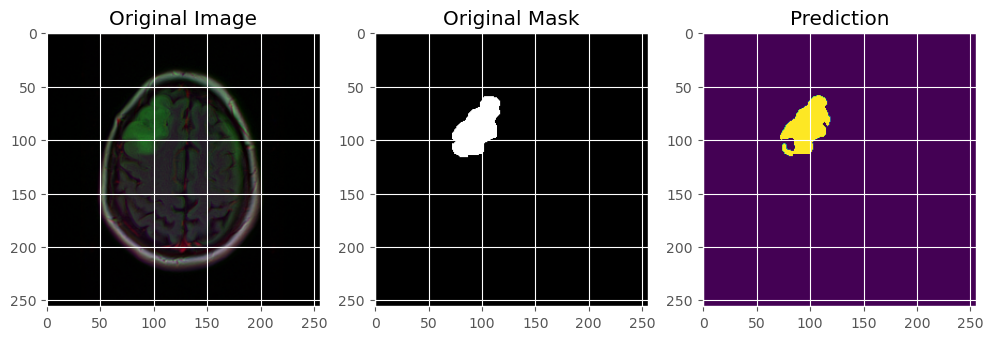

1/1 [==============================] - 0s 21ms/step


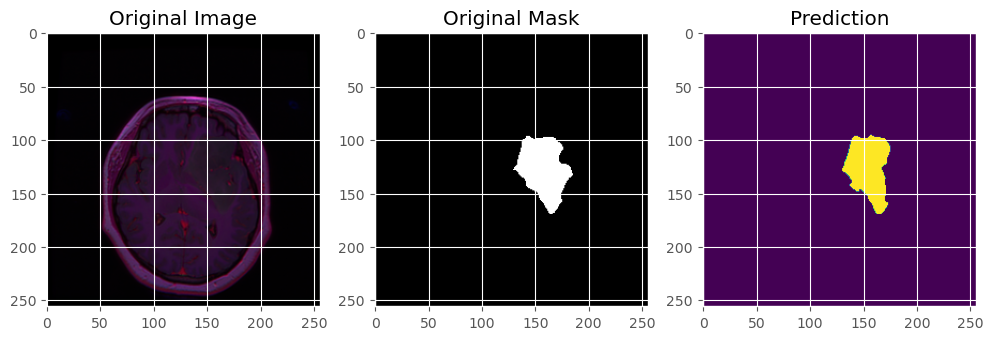

1/1 [==============================] - 0s 21ms/step


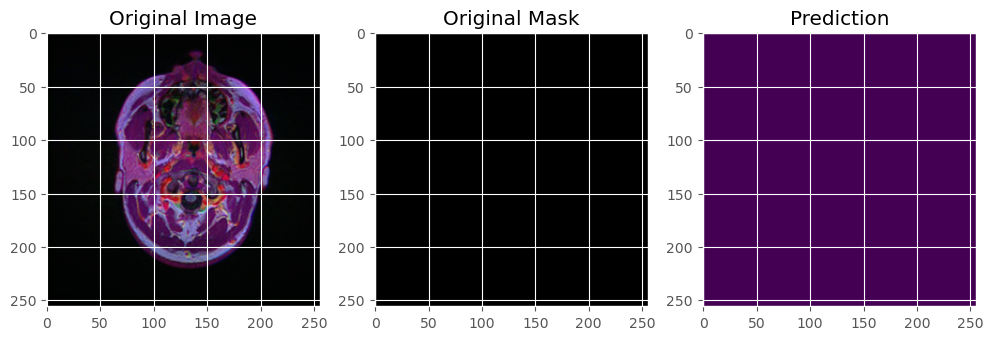

1/1 [==============================] - 0s 20ms/step


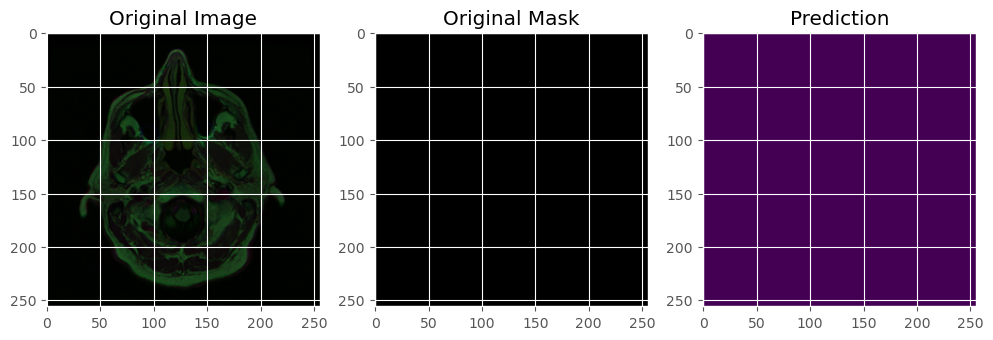

1/1 [==============================] - 0s 20ms/step


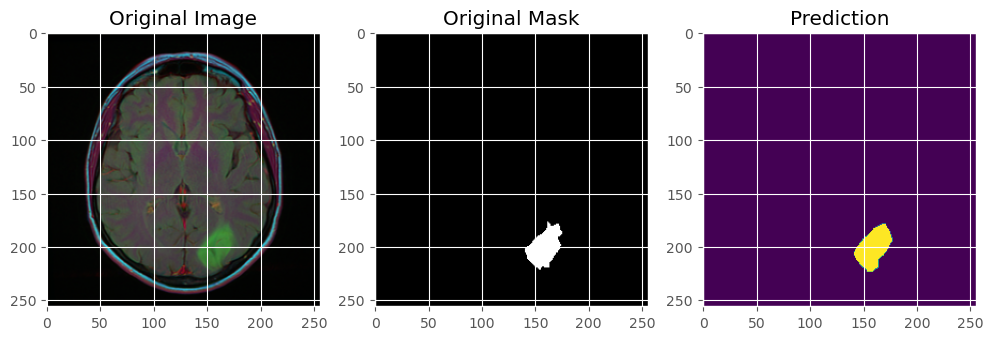

1/1 [==============================] - 0s 22ms/step


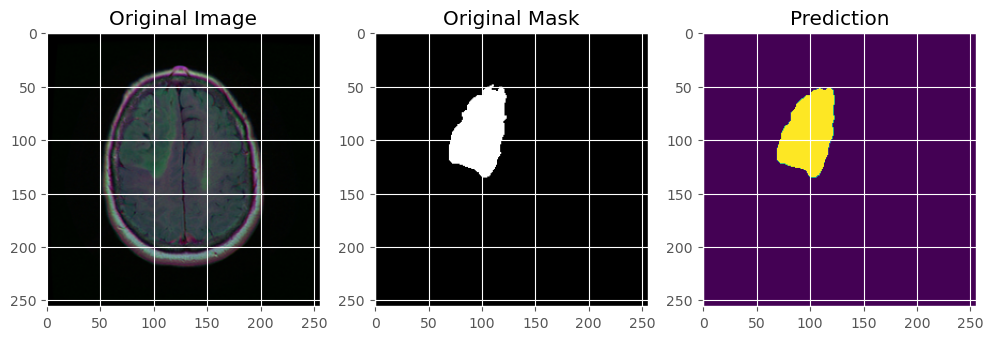

1/1 [==============================] - 0s 21ms/step


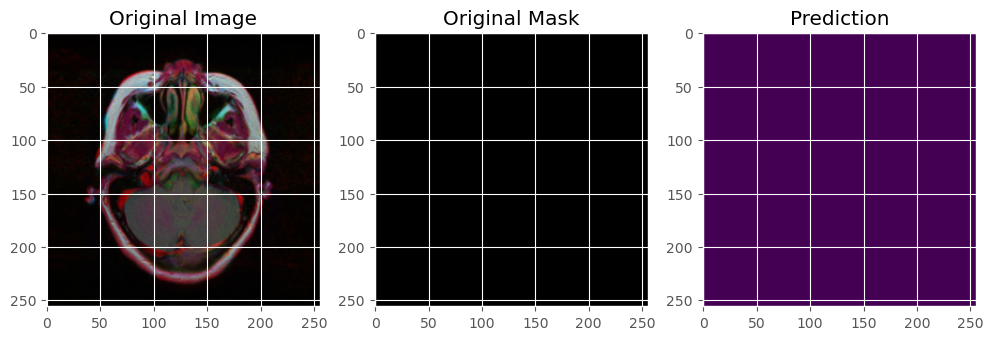

1/1 [==============================] - 0s 21ms/step


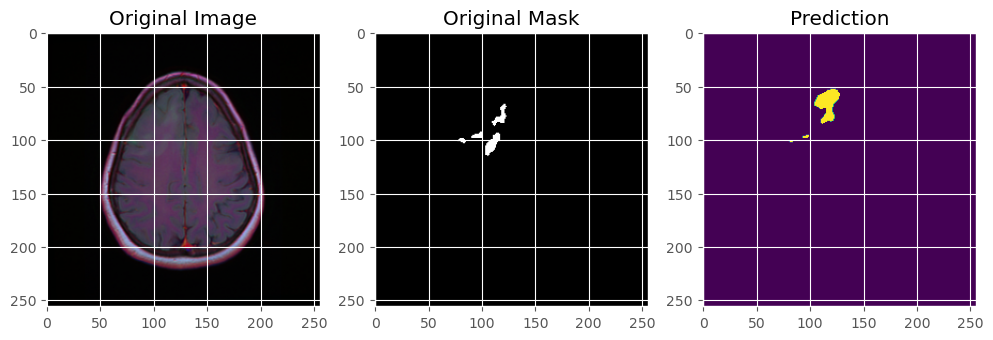

1/1 [==============================] - 0s 21ms/step


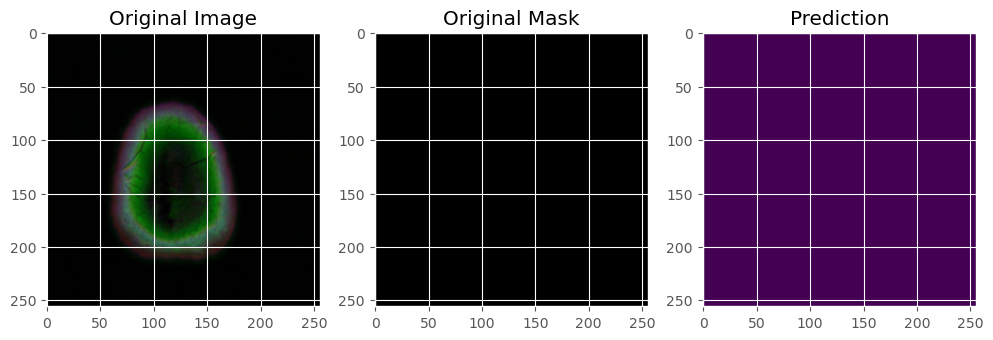

In [19]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()


In [20]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficient_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } ,compile=False)

1/1 [==============================] - 0s 324ms/step


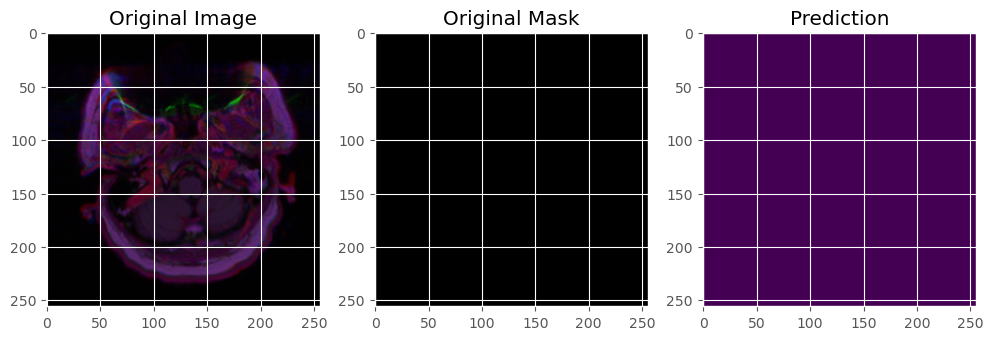

1/1 [==============================] - 0s 21ms/step


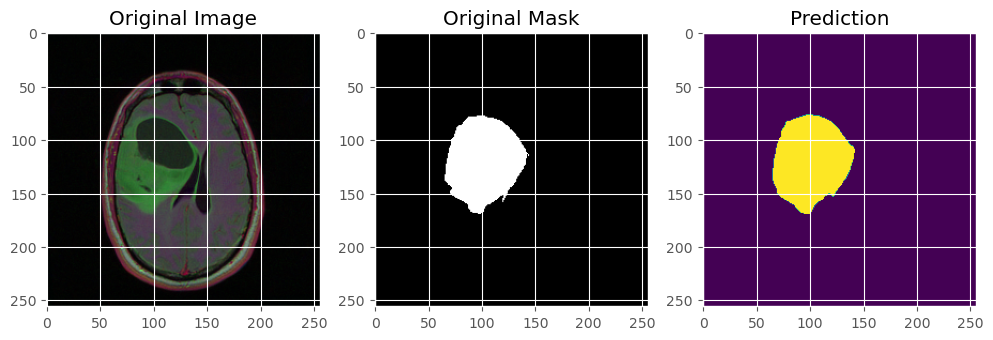

1/1 [==============================] - 0s 20ms/step


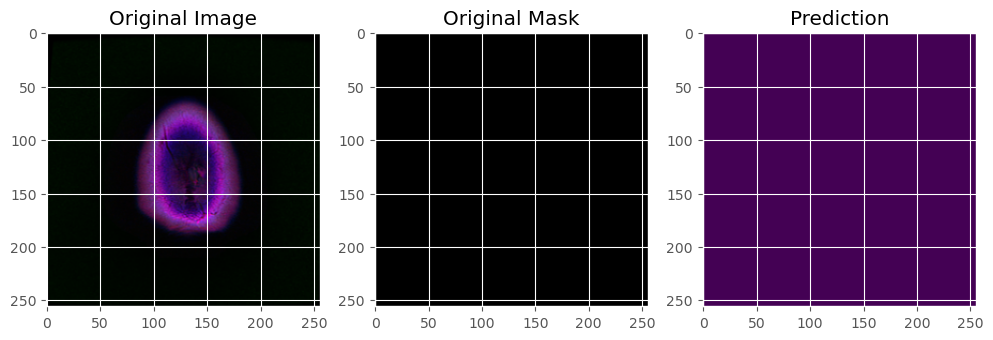

1/1 [==============================] - 0s 22ms/step


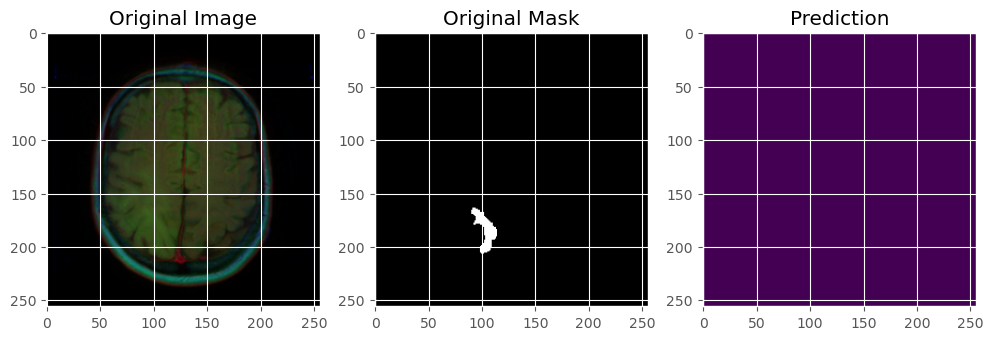

1/1 [==============================] - 0s 21ms/step


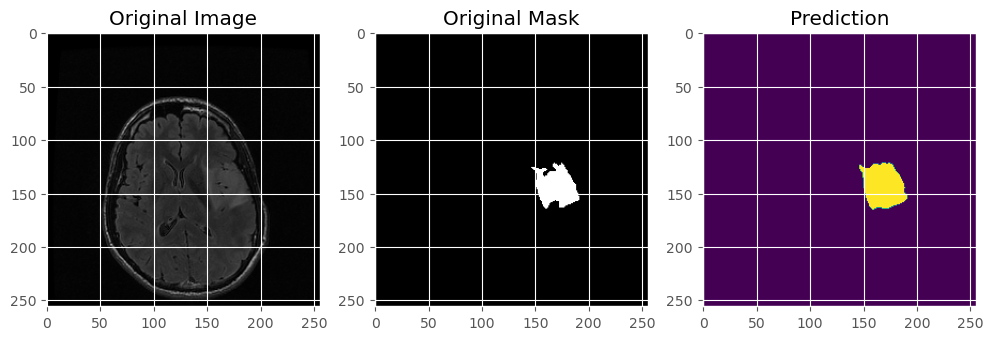

1/1 [==============================] - 0s 20ms/step


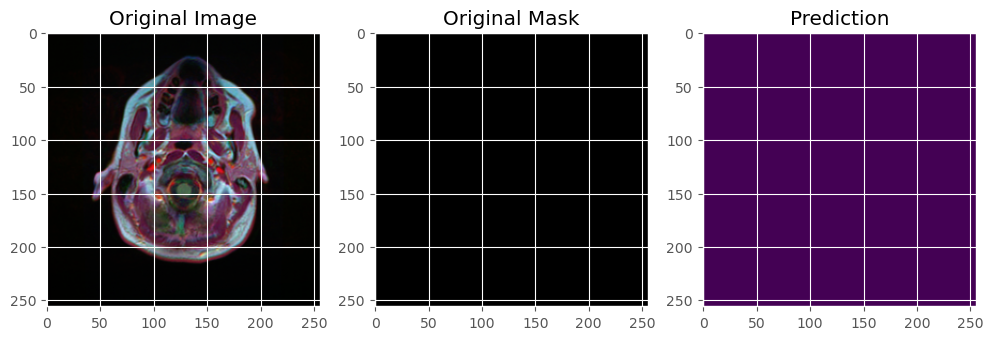

1/1 [==============================] - 0s 20ms/step


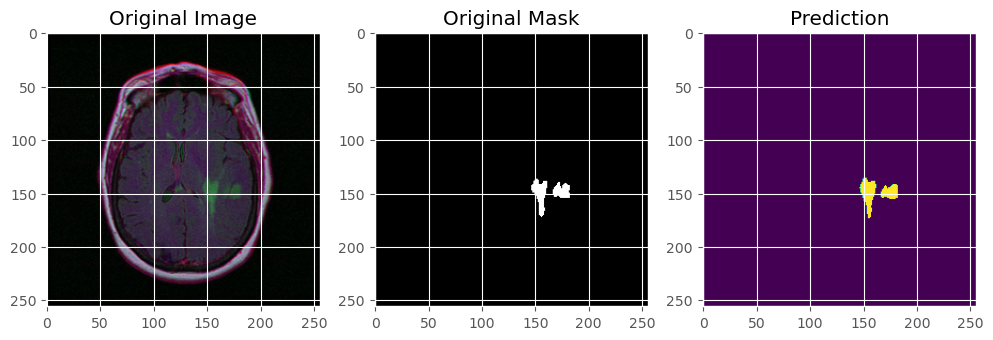

1/1 [==============================] - 0s 20ms/step


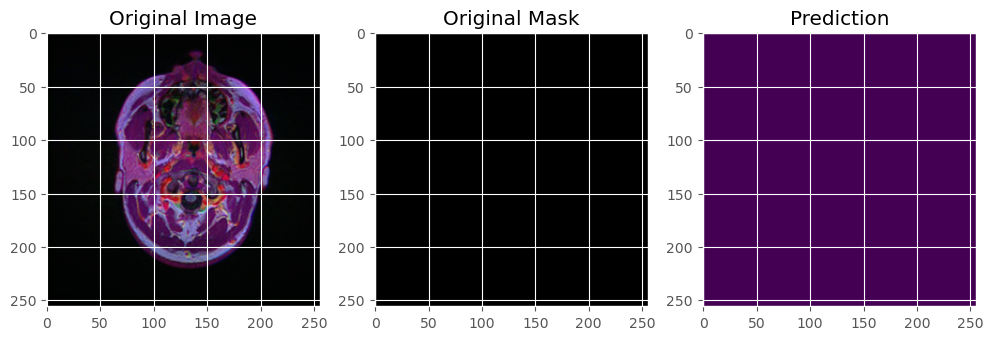

In [21]:
for i in range(8):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

In [22]:
model = load_model('/kaggle/input/unethdf5/unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficient_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } ,compile=False)

1/1 [==============================] - 0s 316ms/step


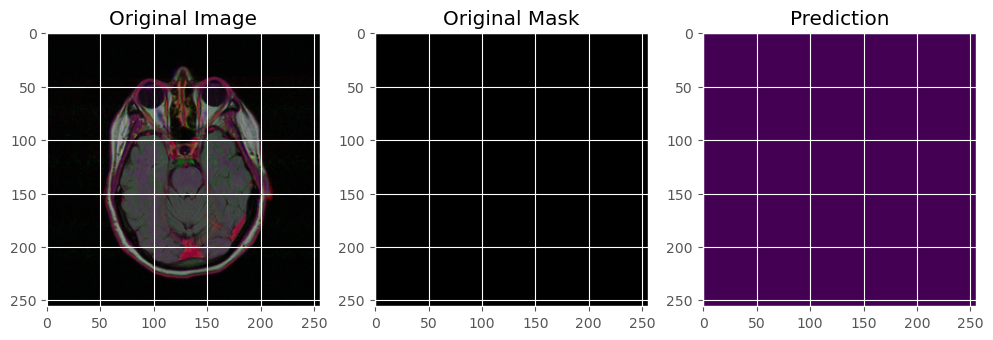

1/1 [==============================] - 0s 19ms/step


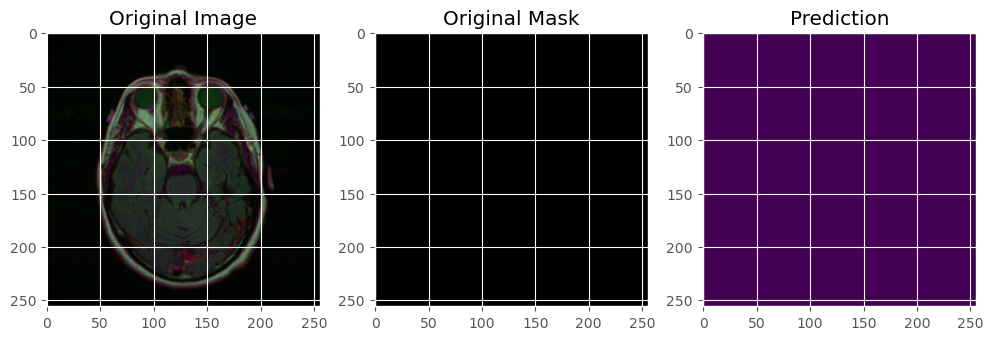

1/1 [==============================] - 0s 23ms/step


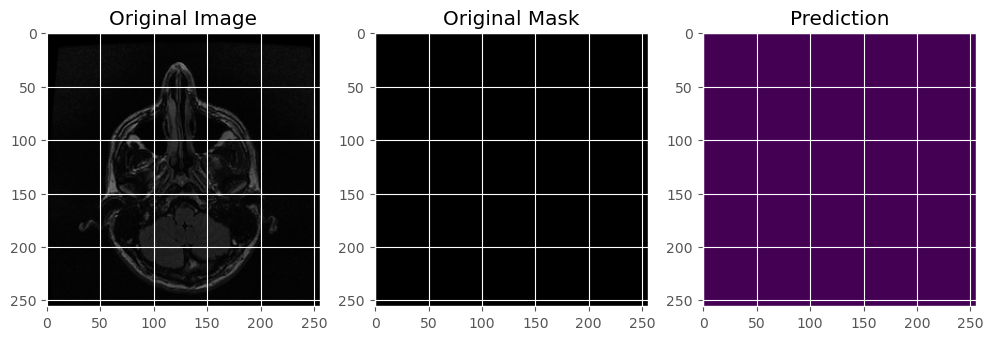

1/1 [==============================] - 0s 22ms/step


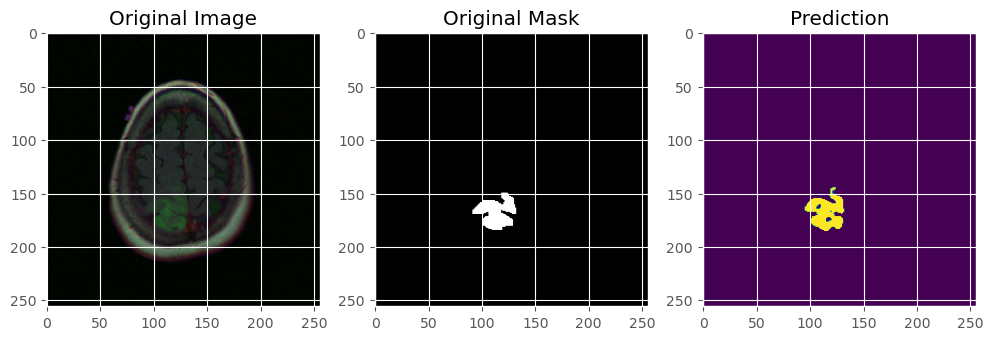

1/1 [==============================] - 0s 21ms/step


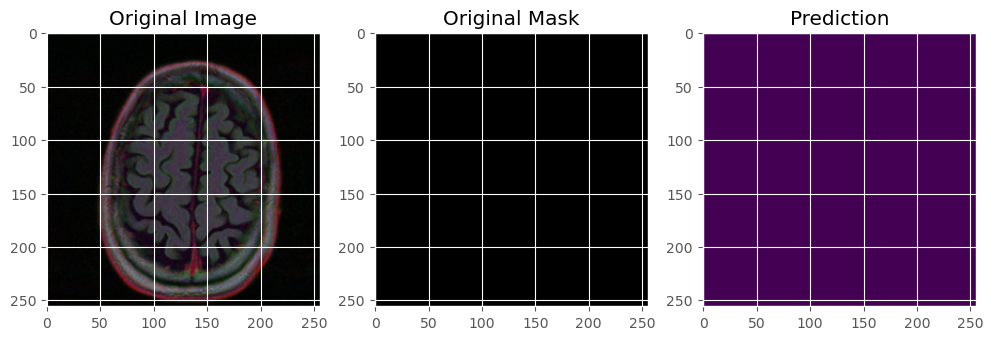

1/1 [==============================] - 0s 20ms/step


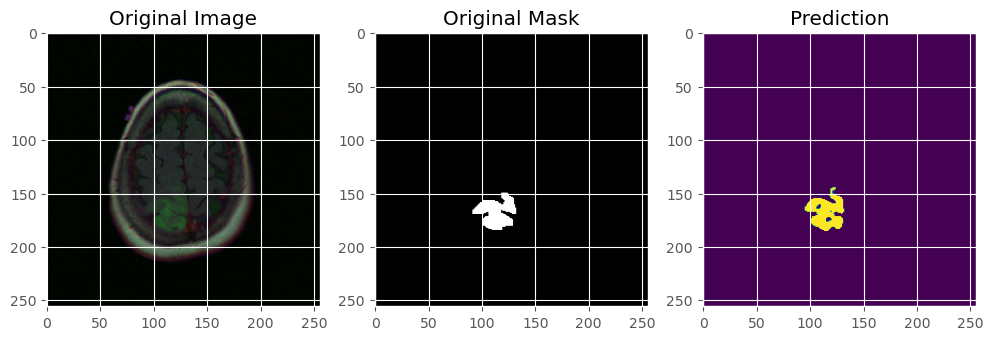

1/1 [==============================] - 0s 20ms/step


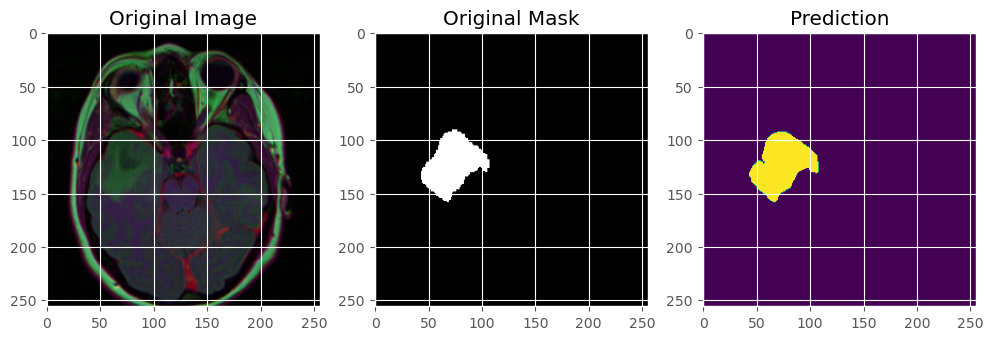

In [23]:
for i in range(7):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()